# 4-7 實作:使用預模型做遷移學習、訓練自己的深度學習模型
# 1 CNN影像分類 (貓狗分類)

[Kaggle競賽(Dogs vs. Cats)](https://www.kaggle.com/competitions/dogs-vs-cats/data?select=train.zip)
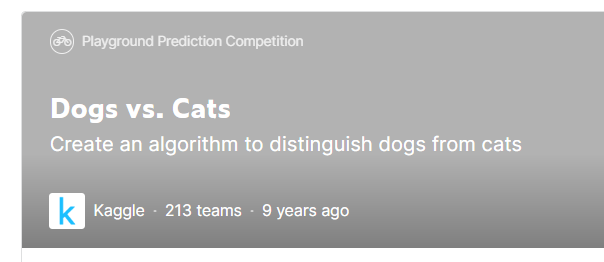
一共有853.96 MB，我們只會用到訓練圖片(訓練檔案包含 25,000 張狗和貓的圖像)。<br>
但25000張訓練圖，可能要訓練很久，我會將圖片壓縮到$64\times 64$的解析下去訓練，我們的目是教會大家如何自行可以訓練自己的資料，所以如果大家有自己的資料也有很強的GPU，你可以將輸入圖片用大一點。<br>
我也會有一個範例用GPU訓練將圖片解析放到224*224並且利用Pytorch提供的ImageNet的preatrain。<br>




In [1]:
import os
import json
mypath = './dataset/dogs-vs-cats/train/train'

imagepaths, labels=[],[]
for (dirpath, _ , filenames) in os.walk(mypath):
    for tmp_filename in filenames:
        if 'cat' in tmp_filename:
            labels.append(0)
        elif 'dog' in tmp_filename:
            labels.append(1)
        imagepaths.append(os.path.join(dirpath, tmp_filename))
data={}
data['imagepaths']=imagepaths
data['labels']=labels
with open('./dataset/dogs-vs-cats/dogcat.json', 'w', newline='') as jsonfile:
    json.dump(data, jsonfile)
    

因為資料庫內有25000張訓練圖，我們希望在大家電腦都能訓練快一點<br>
我們採用sklearn內的```train_test_split```函數，20%當作訓練(也就是5000張圖當訓練)，剩下80%當作測試(也就是20000張當測試)。

number of total train data:5000
number of total test data:20000
number of total train data:5000
number of total test data:20000
torch.Size([16, 3, 64, 64])
torch.Size([16])
tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1])


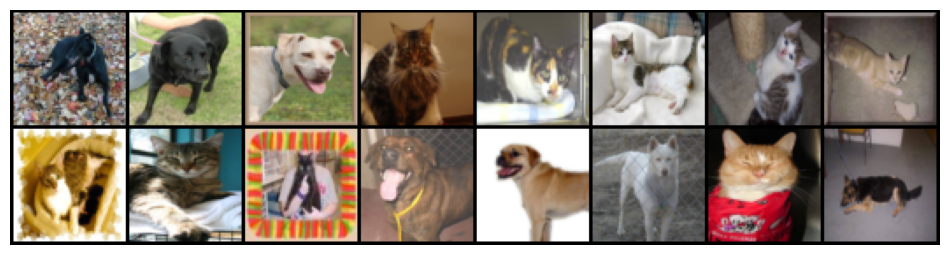

tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1])


In [2]:
import torch
import PIL.Image as Image
import torchvision.transforms.functional as FT
from torchvision import transforms
import json
from sklearn.model_selection import train_test_split


class MyDataset_CatDog(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self,mytransform, istrain=1):
        
        with open('./dataset/dogs-vs-cats/dogcat.json') as jsonfile:
            data_load = json.load(jsonfile)
            
        train_paths, test_paths, train_label, test_label = train_test_split(data_load['imagepaths'],
                                                                            data_load['labels'], 
                                                                            test_size=0.8, 
                                                                            random_state=2023)
        if istrain:
            self.imList = train_paths
            self.labelList = train_label
        else:
            self.imList = test_paths
            self.labelList = test_label    
        self.mytransform = mytransform
            
        print('number of total train data:{}'.format(len(train_paths)))
        print('number of total test data:{}'.format(len(test_paths)))
        
    def __len__(self):
        return len(self.imList)

    def __getitem__(self, idx):
        '''
        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.imList[idx]
        label = self.labelList[idx]
        
        # read image with PIL module
        image = Image.open(image_name, mode='r')
        image = image.convert('RGB')
        
        # Convert PIL label image to torch.Tensor
        image = self.mytransform(image)
        label = torch.tensor(label)
        
        return image, label
    
    def my_collate(self,batch):
        data, targets = list(), list()
        for b in batch:
            data.append(b[0])
            targets.append(b[1])
        data = torch.stack(data,dim=0)
        targets = torch.stack(targets,dim=0)
        return data, targets

    
mytransform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    ])

mydataset_train = MyDataset_CatDog(mytransform=mytransform, istrain=1)
mydataset_test  = MyDataset_CatDog(mytransform=mytransform, istrain=0)
dataloader_train = torch.utils.data.DataLoader(mydataset_train, batch_size=16, shuffle=True ,num_workers=0)
dataloader_test = torch.utils.data.DataLoader(mydataset_test, batch_size=16, shuffle=True ,num_workers=0)
for data, targets in dataloader_train:
    print(data.size())
    print(targets.size())
    print(targets)
    break    

# 圖片視覺化
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

grid = make_grid(data)
def show(image):
    plt.figure(figsize=(12, 9))
    plt.imshow(np.transpose(image, [1, 2, 0]))
    plt.axis('off')
show(grid)
plt.show()
print(targets)

### 我們這邊採用transfer learning(遷移學習)，從TorchVision內直接採用ImageNet訓練好的pretrain weight。


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class MyClassificationModel(nn.Module):
    def __init__(self, n_class, modelname='mobilenetv2'):
        super(MyClassificationModel, self).__init__()
        
        if modelname=='resnet18':
            model_conv = models.resnet18(pretrained=True)
            num_ftrs = model_conv.fc.in_features
        elif modelname=='mobilenetv2':
            model_conv = models.mobilenet_v2(pretrained=True)
            num_ftrs = model_conv.classifier[1].in_features
        else:
            print('Please choice a model, resnet18, mobilenetv2')
        for param in model_conv.parameters():
            param.requires_grad = False
            
        if modelname=='resnet18':
            num_ftrs = model_conv.fc.in_features
            model_conv.fc = nn.Linear(num_ftrs, n_class)
        elif modelname=='mobilenetv2':
            num_ftrs = model_conv.classifier[1].in_features
            model_conv.classifier[1] = nn.Linear(num_ftrs, n_class)
        
        self.model_conv=model_conv
        
    def forward(self, x):
        return self.model_conv(x)


mymodel = MyClassificationModel(n_class=2, modelname='mobilenetv2')
dummy_input = torch.randn(1, 3, 64, 64)
out = mymodel(dummy_input)
torch.onnx.export(mymodel, dummy_input, "mymodel.onnx", opset_version=11) 

C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [4]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import PIL.Image as Image
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim
import numpy as np

# 步驟0. 是否使用CUDA 
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)
# 1. data loader處理 
mytransform=transforms.Compose([
    transforms.4Resize((64,6)),
    transforms.ToTensor(),
    ])

mydataset_train = MyDataset_CatDog(mytransform=mytransform, istrain=1)
mydataset_test  = MyDataset_CatDog(mytransform=mytransform, istrain=0)
dataloader_train = torch.utils.data.DataLoader(mydataset_train, batch_size=256, shuffle=True ,num_workers=0)
dataloader_test = torch.utils.data.DataLoader(mydataset_test, batch_size=256, shuffle=False ,num_workers=0)
# 2. Model
mymodel = MyClassificationModel(n_class=2, modelname='mobilenetv2')
mymodel = mymodel.to(device)

# 3. loss function宣告
loss = torch.nn.CrossEntropyLoss().to(device)

# 4. optimator宣告
#   scheduler: MultiStepLR
optimizer = torch.optim.SGD(mymodel.parameters(), lr=0.01,momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15,20,25], gamma=0.5)

cuda
number of total train data:5000
number of total test data:20000
number of total train data:5000
number of total test data:20000


In [5]:
from tqdm import tqdm

def evalmodel(model, dataloader, loss):
    model.eval()
    loss_record, correct, total   = 0,0,0
    with torch.no_grad():
        for batch_idx, (data, targets) in tqdm(enumerate(dataloader)):
            data, targets = data.to(device), targets.to(device)
            outputs= model(data)
            loss_model = loss(outputs,targets)  
            loss_record += loss_model
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    loss_record /= len(dataloader)
    acc = 100 * correct / total
    return loss_model.cpu().detach().numpy(), acc


# 步驟5. 模型開始訓練
total_epoch=20
plt_loss_train, plt_loss_test=[],[]
plt_acc_train, plt_acc_test=[],[]
for epoch in range(total_epoch):
    print('learning rate:{}'.format(scheduler.get_last_lr()[0]))
    # train
    mymodel.train()
    train_loss_mlp = 0
    for batch_idx, (data, targets) in tqdm(enumerate(dataloader_train)):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = mymodel(data)
        loss_model = loss(outputs, targets)  
        loss_model.backward()
        optimizer.step()
    scheduler.step()
    
    # eval
    loss_model_train, acc_train = evalmodel(mymodel, dataloader_train, loss)
    loss_model_test, acc_test = evalmodel(mymodel, dataloader_test, loss)
    plt_loss_train.append(loss_model_train)
    plt_loss_test.append(loss_model_test)
    plt_acc_train.append(acc_train)
    plt_acc_test.append(acc_test)
    if epoch % 1 ==0:
        
        print('[epoch: {}/{}], Loss(Train):{:.10f}, Loss(Test):{:.10f}, Acc(Train):{:.10f}, Acc(Test):{:.10f}'.format(
              epoch+1, total_epoch, 
              loss_model_train,
              loss_model_test,
              acc_train,
              acc_test,
            ))
print('training done.')


learning rate:0.01


20it [00:15,  1.33it/s]
20it [00:14,  1.40it/s]
79it [00:56,  1.41it/s]


[epoch: 1/20], Loss(Train):0.5551676750, Loss(Test):0.5484980941, Acc(Train):72.9200000000, Acc(Test):71.3800000000
learning rate:0.01


20it [00:12,  1.67it/s]
20it [00:14,  1.40it/s]
79it [00:54,  1.45it/s]


[epoch: 2/20], Loss(Train):0.6034937501, Loss(Test):0.7144662142, Acc(Train):77.7600000000, Acc(Test):75.2050000000
learning rate:0.01


20it [00:12,  1.66it/s]
20it [00:13,  1.49it/s]
79it [00:54,  1.46it/s]


[epoch: 3/20], Loss(Train):0.4587829709, Loss(Test):0.5890084505, Acc(Train):80.9600000000, Acc(Test):76.4150000000
learning rate:0.01


20it [00:11,  1.69it/s]
20it [00:13,  1.52it/s]
79it [00:53,  1.49it/s]


[epoch: 4/20], Loss(Train):0.4573557973, Loss(Test):0.7270290256, Acc(Train):77.3600000000, Acc(Test):73.9550000000
learning rate:0.01


20it [00:11,  1.68it/s]
20it [00:13,  1.44it/s]
79it [00:54,  1.46it/s]


[epoch: 5/20], Loss(Train):0.3431344628, Loss(Test):0.5640326738, Acc(Train):83.3400000000, Acc(Test):76.9700000000
learning rate:0.01


20it [00:12,  1.58it/s]
20it [00:13,  1.49it/s]
79it [00:55,  1.41it/s]


[epoch: 6/20], Loss(Train):0.3302125931, Loss(Test):0.6147164106, Acc(Train):82.8800000000, Acc(Test):76.1200000000
learning rate:0.01


20it [00:12,  1.60it/s]
20it [00:15,  1.26it/s]
79it [00:56,  1.41it/s]


[epoch: 7/20], Loss(Train):0.3291672468, Loss(Test):0.6037673354, Acc(Train):83.3600000000, Acc(Test):77.0000000000
learning rate:0.01


20it [00:12,  1.57it/s]
20it [00:15,  1.33it/s]
79it [00:57,  1.38it/s]


[epoch: 8/20], Loss(Train):0.4094516337, Loss(Test):0.6854048967, Acc(Train):83.0400000000, Acc(Test):76.6450000000
learning rate:0.01


20it [00:12,  1.66it/s]
20it [00:14,  1.42it/s]
79it [00:56,  1.40it/s]


[epoch: 9/20], Loss(Train):0.3565190434, Loss(Test):0.6108025908, Acc(Train):82.5400000000, Acc(Test):75.9850000000
learning rate:0.01


20it [00:12,  1.63it/s]
20it [00:13,  1.48it/s]
79it [00:55,  1.43it/s]


[epoch: 10/20], Loss(Train):0.3571976125, Loss(Test):0.6137174964, Acc(Train):84.6000000000, Acc(Test):76.6600000000
learning rate:0.005


20it [00:12,  1.66it/s]
20it [00:13,  1.45it/s]
79it [00:56,  1.39it/s]


[epoch: 11/20], Loss(Train):0.3431205750, Loss(Test):0.6461258531, Acc(Train):83.5600000000, Acc(Test):76.3300000000
learning rate:0.005


20it [00:12,  1.64it/s]
20it [00:14,  1.38it/s]
79it [00:59,  1.33it/s]


[epoch: 12/20], Loss(Train):0.5056570768, Loss(Test):0.6593046784, Acc(Train):80.7800000000, Acc(Test):73.9300000000
learning rate:0.005


20it [00:12,  1.57it/s]
20it [00:14,  1.35it/s]
79it [00:56,  1.39it/s]


[epoch: 13/20], Loss(Train):0.3543841243, Loss(Test):0.6137972474, Acc(Train):84.3200000000, Acc(Test):77.0650000000
learning rate:0.005


20it [00:12,  1.63it/s]
20it [00:14,  1.41it/s]
79it [00:56,  1.40it/s]


[epoch: 14/20], Loss(Train):0.3333326280, Loss(Test):0.6462860703, Acc(Train):82.6400000000, Acc(Test):76.2400000000
learning rate:0.005


20it [00:12,  1.62it/s]
20it [00:13,  1.48it/s]
79it [00:54,  1.46it/s]


[epoch: 15/20], Loss(Train):0.3572284579, Loss(Test):0.6146995425, Acc(Train):84.6000000000, Acc(Test):76.8950000000
learning rate:0.0025


20it [00:12,  1.66it/s]
20it [00:13,  1.52it/s]
79it [00:54,  1.45it/s]


[epoch: 16/20], Loss(Train):0.3587373793, Loss(Test):0.6199465990, Acc(Train):84.3800000000, Acc(Test):77.1450000000
learning rate:0.0025


20it [00:11,  1.69it/s]
20it [00:13,  1.50it/s]
79it [00:52,  1.52it/s]


[epoch: 17/20], Loss(Train):0.3093475103, Loss(Test):0.5856843591, Acc(Train):84.6200000000, Acc(Test):77.0150000000
learning rate:0.0025


20it [00:11,  1.72it/s]
20it [00:13,  1.52it/s]
79it [00:52,  1.50it/s]


[epoch: 18/20], Loss(Train):0.3779933453, Loss(Test):0.6370931864, Acc(Train):82.4800000000, Acc(Test):75.5950000000
learning rate:0.0025


20it [00:11,  1.71it/s]
20it [00:13,  1.53it/s]
79it [00:55,  1.42it/s]


[epoch: 19/20], Loss(Train):0.3945911527, Loss(Test):0.6215344071, Acc(Train):84.3800000000, Acc(Test):76.8700000000
learning rate:0.0025


20it [00:13,  1.47it/s]
20it [00:13,  1.47it/s]
79it [00:56,  1.40it/s]

[epoch: 20/20], Loss(Train):0.3289409578, Loss(Test):0.6047611833, Acc(Train):85.1800000000, Acc(Test):77.2150000000
training done.


訓練模型儲存

In [6]:
checkpoint={}
checkpoint['model']=mymodel
checkpoint['plt_loss_train']=plt_loss_train
checkpoint['plt_loss_test']=plt_loss_test
checkpoint['plt_acc_train']=plt_acc_train
checkpoint['plt_acc_test']=plt_acc_test
torch.save(checkpoint, 'model_catdog_withoutDA.pth')

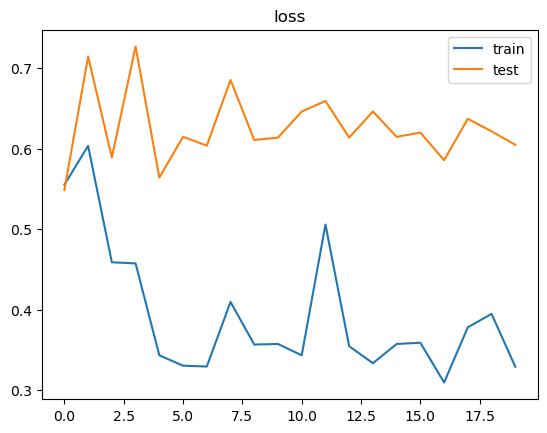

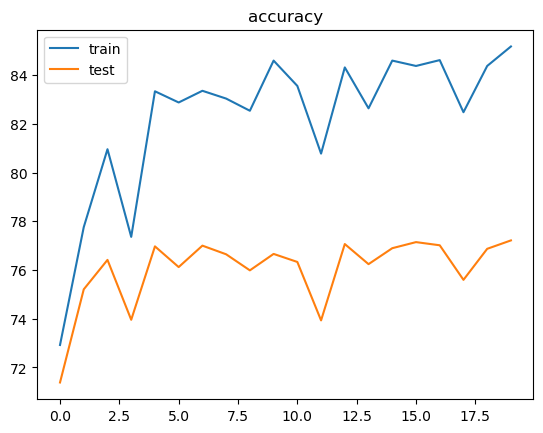

In [7]:
plt.plot(plt_loss_train,label='train')
plt.plot(plt_loss_test,label='test')
plt.title('loss')
plt.legend()
plt.show()

plt.plot(plt_acc_train,label='train')
plt.plot(plt_acc_test,label='test')
plt.title('accuracy')
plt.legend()
plt.show()

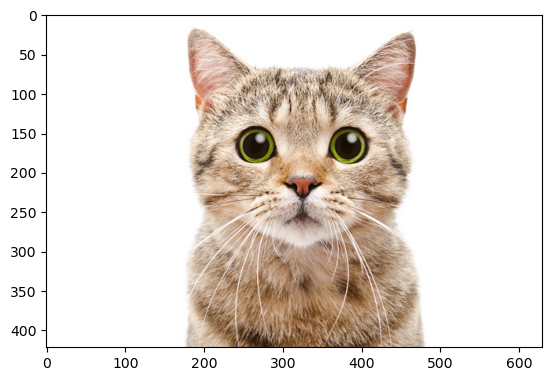

probability for cat: 73.2846%
probability for dog: 26.7154%


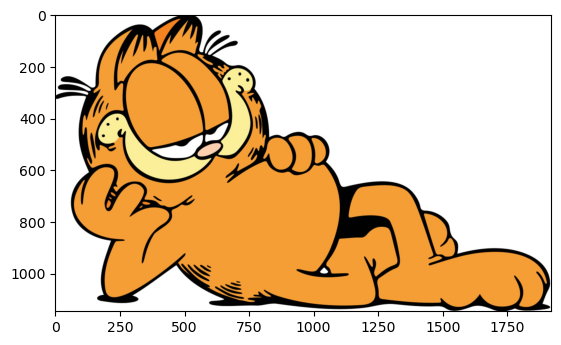

probability for cat: 39.3463%
probability for dog: 60.6537%


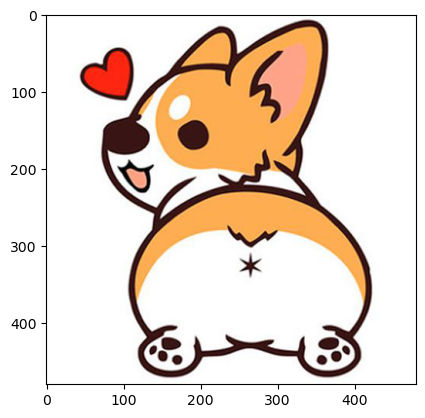

probability for cat: 51.3806%
probability for dog: 48.6194%


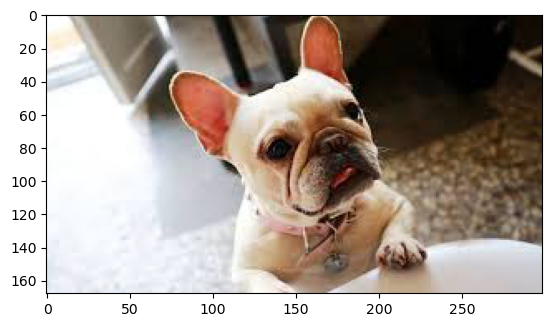

probability for cat: 72.9167%
probability for dog: 27.0833%


In [8]:

mytransform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()
        ])
mymodel.eval()  

image_names = ['./dataset/dogs-vs-cats/cat1.jpg',
               './dataset/dogs-vs-cats/cat2.jpg',
               './dataset/dogs-vs-cats/dog1.jpg',
               './dataset/dogs-vs-cats/dog2.jpg',]

for image_name in image_names:
    image = Image.open(image_name, mode='r')
    image = image.convert('RGB')

    plt.imshow(image)
    plt.show()
    
    image = mytransform(image) # 3, 64, 64
    image = torch.unsqueeze(image,dim=0).to(device) # 1, 3, 64, 64
    with torch.no_grad():
        result = mymodel(image)
    result= F.softmax(result)

    list_class = ['cat','dog']
    for i, tmp_out in enumerate(result[0]):
        print('probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))


## 加入Data Augumentation到訓練流程內

In [9]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import PIL.Image as Image
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim
import numpy as np
from tqdm import tqdm


# 步驟0. 是否使用CUDA 
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)
# 1. data loader處理 
mytransform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    ])


transform_set = [ 
            transforms.RandomCrop(32, padding=4),
            transforms.RandomRotation(degrees=(-15,15)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=(0.8, 1.3), contrast=(
                        0.8, 1.3), saturation=(.8, 1.3), hue=(-0.1, 0.1))]
mytransform_wDA = transforms.Compose([
                            transforms.RandomApply(transform_set, p=0.3),
                            transforms.Resize((64,64)),
                            transforms.ToTensor()])

mydataset_train = MyDataset_CatDog(mytransform=mytransform_wDA, istrain=1)
mydataset_test  = MyDataset_CatDog(mytransform=mytransform, istrain=0)
dataloader_train = torch.utils.data.DataLoader(mydataset_train, batch_size=256, shuffle=True ,num_workers=0)
dataloader_test = torch.utils.data.DataLoader(mydataset_test, batch_size=256, shuffle=False ,num_workers=0)
# 2. Model
mymodel_da = MyClassificationModel(n_class=2, modelname='mobilenetv2')
mymodel_da = mymodel_da.to(device)

# 3. loss function宣告
loss = torch.nn.CrossEntropyLoss().to(device)

# 4. optimator宣告
#   scheduler: MultiStepLR
optimizer = torch.optim.SGD(mymodel_da.parameters(), lr=0.01,momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15,20,25], gamma=0.5)

# 步驟5. 模型開始訓練
total_epoch=20
plt_loss_train_da, plt_loss_test_da=[],[]
plt_acc_train_da, plt_acc_test_da=[],[]
for epoch in range(total_epoch):
    print('learning rate:{}'.format(scheduler.get_last_lr()[0]))
    # train
    mymodel.train()
    train_loss_mlp = 0
    for batch_idx, (data, targets) in tqdm(enumerate(dataloader_train)):
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = mymodel_da(data)
        loss_model = loss(outputs, targets)  
        loss_model.backward()
        optimizer.step()
    scheduler.step()
    
    # eval
    loss_model_train, acc_train = evalmodel(mymodel_da, dataloader_train, loss)
    loss_model_test, acc_test = evalmodel(mymodel_da, dataloader_test, loss)
    plt_loss_train_da.append(loss_model_train)
    plt_loss_test_da.append(loss_model_test)
    plt_acc_train_da.append(acc_train)
    plt_acc_test_da.append(acc_test)
    if epoch % 1 ==0:
        
        print('[epoch: {}/{}], Loss(Train):{:.10f}, Loss(Test):{:.10f}, Acc(Train):{:.10f}, Acc(Test):{:.10f}'.format(
              epoch+1, total_epoch, 
              loss_model_train,
              loss_model_test,
              acc_train,
              acc_test,
            ))
print('training done.')

cuda
number of total train data:5000
number of total test data:20000
number of total train data:5000
number of total test data:20000
learning rate:0.01


20it [00:13,  1.45it/s]
20it [00:15,  1.32it/s]
79it [00:54,  1.46it/s]


[epoch: 1/20], Loss(Train):0.6582768559, Loss(Test):0.6153717637, Acc(Train):66.8000000000, Acc(Test):71.2850000000
learning rate:0.01


20it [00:12,  1.55it/s]
20it [00:13,  1.44it/s]
79it [00:51,  1.53it/s]


[epoch: 2/20], Loss(Train):0.6405978203, Loss(Test):0.5460305810, Acc(Train):71.7600000000, Acc(Test):75.4350000000
learning rate:0.01


20it [00:12,  1.62it/s]
20it [00:14,  1.42it/s]
79it [00:52,  1.50it/s]


[epoch: 3/20], Loss(Train):0.5702559948, Loss(Test):0.4961778522, Acc(Train):72.5000000000, Acc(Test):77.2850000000
learning rate:0.01


20it [00:12,  1.61it/s]
20it [00:14,  1.43it/s]
79it [00:52,  1.51it/s]


[epoch: 4/20], Loss(Train):0.6239427924, Loss(Test):0.4848884344, Acc(Train):71.7000000000, Acc(Test):75.2050000000
learning rate:0.01


20it [00:12,  1.56it/s]
20it [00:14,  1.41it/s]
79it [00:52,  1.50it/s]


[epoch: 5/20], Loss(Train):0.4818840027, Loss(Test):0.5128697157, Acc(Train):74.7400000000, Acc(Test):77.0500000000
learning rate:0.01


20it [00:12,  1.62it/s]
20it [00:13,  1.44it/s]
79it [00:52,  1.52it/s]


[epoch: 6/20], Loss(Train):0.4552028477, Loss(Test):0.4603299797, Acc(Train):74.0000000000, Acc(Test):77.6000000000
learning rate:0.01


20it [00:12,  1.61it/s]
20it [00:14,  1.41it/s]
79it [00:51,  1.55it/s]


[epoch: 7/20], Loss(Train):0.4879529178, Loss(Test):0.4834248126, Acc(Train):74.8000000000, Acc(Test):77.6900000000
learning rate:0.01


20it [00:12,  1.65it/s]
20it [00:13,  1.47it/s]
79it [00:51,  1.54it/s]


[epoch: 8/20], Loss(Train):0.4554851651, Loss(Test):0.4922012687, Acc(Train):75.7200000000, Acc(Test):77.1800000000
learning rate:0.01


20it [00:12,  1.62it/s]
20it [00:13,  1.47it/s]
79it [00:51,  1.55it/s]


[epoch: 9/20], Loss(Train):0.4533598125, Loss(Test):0.5190402269, Acc(Train):76.1200000000, Acc(Test):77.4250000000
learning rate:0.01


20it [00:12,  1.63it/s]
20it [00:13,  1.44it/s]
79it [00:51,  1.54it/s]


[epoch: 10/20], Loss(Train):0.4338133037, Loss(Test):0.5207504034, Acc(Train):75.0200000000, Acc(Test):77.7350000000
learning rate:0.005


20it [00:12,  1.65it/s]
20it [00:13,  1.47it/s]
79it [00:51,  1.53it/s]


[epoch: 11/20], Loss(Train):0.4867274761, Loss(Test):0.5233725309, Acc(Train):75.3600000000, Acc(Test):77.5850000000
learning rate:0.005


20it [00:12,  1.65it/s]
20it [00:13,  1.47it/s]
79it [00:51,  1.54it/s]


[epoch: 12/20], Loss(Train):0.4195020497, Loss(Test):0.5256351233, Acc(Train):75.3400000000, Acc(Test):77.5900000000
learning rate:0.005


20it [00:12,  1.64it/s]
20it [00:13,  1.49it/s]
79it [00:50,  1.55it/s]


[epoch: 13/20], Loss(Train):0.4566890299, Loss(Test):0.5145350099, Acc(Train):76.4600000000, Acc(Test):77.8500000000
learning rate:0.005


20it [00:12,  1.64it/s]
20it [00:13,  1.46it/s]
79it [00:51,  1.54it/s]


[epoch: 14/20], Loss(Train):0.4009854496, Loss(Test):0.4988451302, Acc(Train):76.2800000000, Acc(Test):77.5850000000
learning rate:0.005


20it [00:12,  1.63it/s]
20it [00:13,  1.47it/s]
79it [00:51,  1.54it/s]


[epoch: 15/20], Loss(Train):0.4677321911, Loss(Test):0.4971203208, Acc(Train):76.4000000000, Acc(Test):77.6850000000
learning rate:0.0025


20it [00:12,  1.64it/s]
20it [00:13,  1.47it/s]
79it [00:50,  1.55it/s]


[epoch: 16/20], Loss(Train):0.4274165332, Loss(Test):0.5154053569, Acc(Train):74.9400000000, Acc(Test):77.6500000000
learning rate:0.0025


20it [00:12,  1.64it/s]
20it [00:14,  1.41it/s]
79it [00:51,  1.54it/s]


[epoch: 17/20], Loss(Train):0.4970442951, Loss(Test):0.5057514906, Acc(Train):76.8000000000, Acc(Test):77.6800000000
learning rate:0.0025


20it [00:12,  1.62it/s]
20it [00:13,  1.46it/s]
79it [00:55,  1.42it/s]


[epoch: 18/20], Loss(Train):0.4787232578, Loss(Test):0.5140478015, Acc(Train):76.5800000000, Acc(Test):77.6250000000
learning rate:0.0025


20it [00:12,  1.61it/s]
20it [00:13,  1.46it/s]
79it [00:51,  1.53it/s]


[epoch: 19/20], Loss(Train):0.4172427654, Loss(Test):0.5107299685, Acc(Train):76.9200000000, Acc(Test):77.6450000000
learning rate:0.0025


20it [00:12,  1.64it/s]
20it [00:13,  1.47it/s]
79it [00:51,  1.52it/s]

[epoch: 20/20], Loss(Train):0.4485156536, Loss(Test):0.5092334747, Acc(Train):77.6600000000, Acc(Test):77.6850000000
training done.


In [10]:
checkpoint={}
checkpoint['model']=mymodel_da
checkpoint['plt_loss_train']=plt_loss_train_da
checkpoint['plt_loss_test']=plt_loss_test_da
checkpoint['plt_acc_train']=plt_acc_train_da
checkpoint['plt_acc_test']=plt_acc_test_da
torch.save(checkpoint, 'model_catdog_withDA.pth')

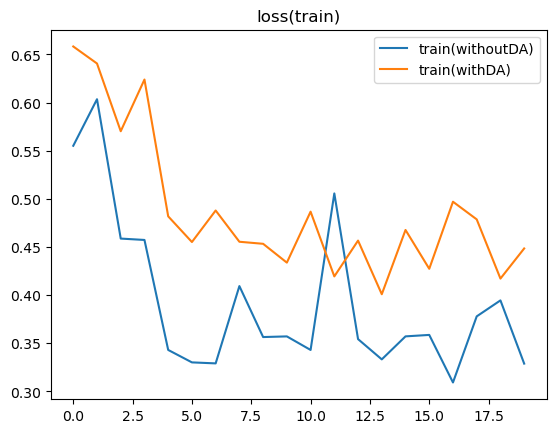

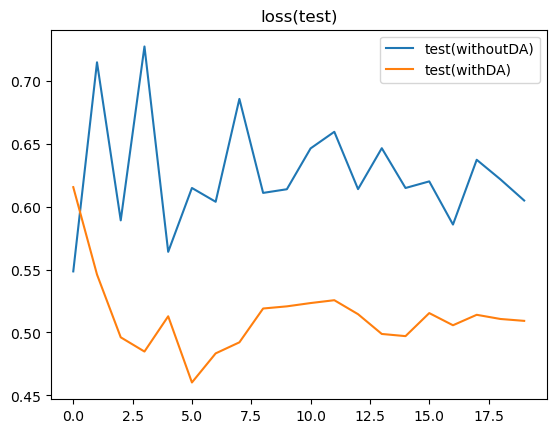

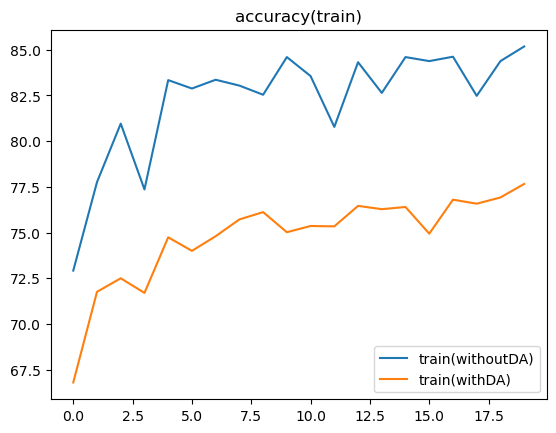

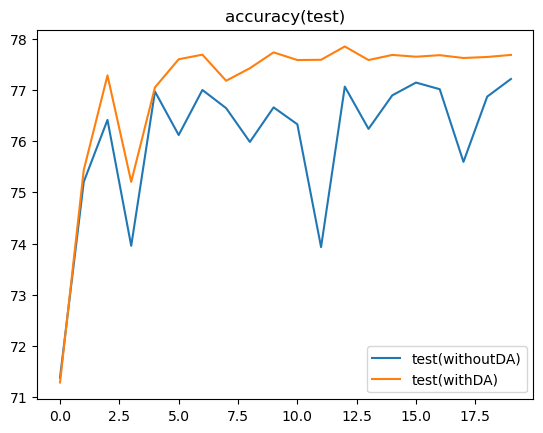

In [11]:
plt.plot(plt_loss_train,label='train(withoutDA)')
plt.plot(plt_loss_train_da,label='train(withDA)')
plt.title('loss(train)')
plt.legend()
plt.show()

plt.plot(plt_loss_test,label='test(withoutDA)')
plt.plot(plt_loss_test_da,label='test(withDA)')
plt.title('loss(test)')
plt.legend()
plt.show()

plt.plot(plt_acc_train,label='train(withoutDA)')
plt.plot(plt_acc_train_da,label='train(withDA)')
plt.title('accuracy(train)')
plt.legend()
plt.show()

plt.plot(plt_acc_test,label='test(withoutDA)')
plt.plot(plt_acc_test_da,label='test(withDA)')
plt.title('accuracy(test)')
plt.legend()
plt.show()

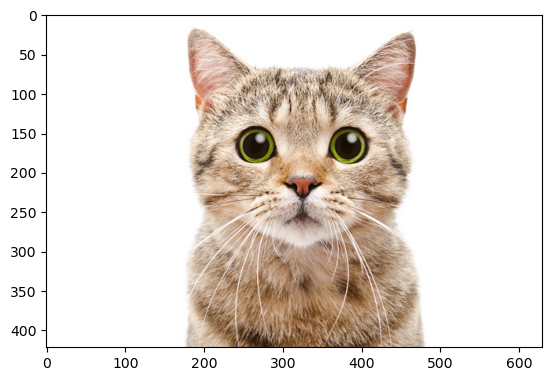

probability for cat: 66.0217%
probability for dog: 33.9783%


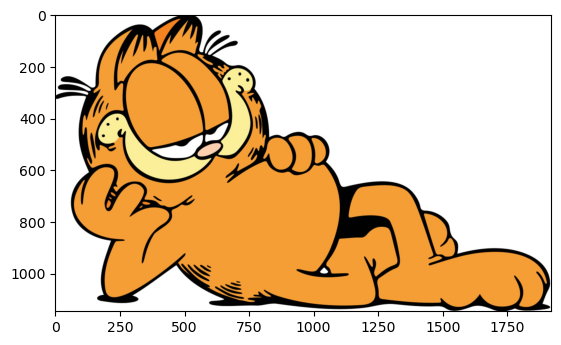

probability for cat: 20.3854%
probability for dog: 79.6146%


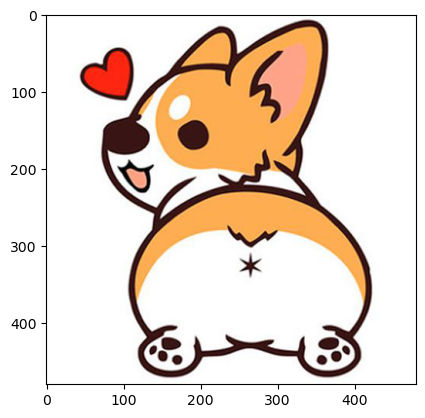

probability for cat: 30.3950%
probability for dog: 69.6050%


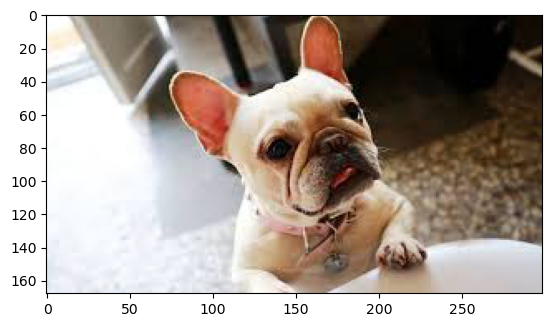

probability for cat: 34.7666%
probability for dog: 65.2334%


In [12]:

mytransform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()
        ])
mymodel_da.eval()  

image_names = ['./dataset/dogs-vs-cats/cat1.jpg',
               './dataset/dogs-vs-cats/cat2.jpg',
               './dataset/dogs-vs-cats/dog1.jpg',
               './dataset/dogs-vs-cats/dog2.jpg',]

for image_name in image_names:
    image = Image.open(image_name, mode='r')
    image = image.convert('RGB')

    plt.imshow(image)
    plt.show()
    
    image = mytransform(image)
    image = torch.unsqueeze(image,dim=0).to(device)
    with torch.no_grad():
        result = mymodel_da(image)
    result= F.softmax(result)

    list_class = ['cat','dog']
    for i, tmp_out in enumerate(result[0]):
        print('probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))
